In [ ]:
#Question 15 and 16
import numpy as np

def trinomial_pricer(S0, K, T, r, sigma, n, option_type='call'):
    """
    Prices a European option using a n-step trinomial tree.

    Args:
        S0 (float): Initial stock price.
        K (float): Strike price.
        T (float): Time to maturity in years.
        r (float): Risk-free interest rate.
        sigma (float): Volatility.
        n (int): Number of steps in the tree.
        option_type (str): 'call' or 'put'.

    Returns:
        float: The price of the European option.
    """
    # 1. Calculate tree parameters based on the Boyle (1986) model
    dt = T / n
    u = np.exp(sigma * np.sqrt(3 * dt))
    d = 1 / u

    # Risk-neutral probabilities
    nu = r - 0.5 * sigma**2
    pu = 1/6 + (nu * np.sqrt(dt)) / (2 * sigma * np.sqrt(3))
    pd = 1/6 - (nu * np.sqrt(dt)) / (2 * sigma * np.sqrt(3))
    pm = 2/3

    discount = np.exp(-r * dt)

    # 2. Initialize stock prices and option values at maturity (t=T)
    # At step n, there are 2n+1 nodes
    # The stock price at node i (from top=0 to bottom=2n) is S0 * u^(n-i)
    stock_prices_T = S0 * (u ** (n - np.arange(2 * n + 1)))

    if option_type == 'call':
        option_values = np.maximum(stock_prices_T - K, 0)
    else:  # put
        option_values = np.maximum(K - stock_prices_T, 0)

    # 3. Backward induction from t=T-dt to t=0
    for j in range(n - 1, -1, -1):
        # At each step j, there are 2j+1 nodes
        new_option_values = np.zeros(2 * j + 1)
        for i in range(len(new_option_values)):
            # Value is the discounted expected value from the three subsequent nodes
            val_up = option_values[i]
            val_mid = option_values[i + 1]
            val_down = option_values[i + 2]

            expected_value = pu * val_up + pm * val_mid + pd * val_down
            new_option_values[i] = discount * expected_value
        option_values = new_option_values

    # The final price is the single value at the root of the tree
    return option_values[0]

# --- Main script to run the calculations ---
# Input parameters
S0 = 100
r = 0.05
sigma = 0.20
T = 0.25  # 3 months
n_steps = 2

# Strike prices for the analysis
strikes = [110, 105, 100, 95, 90]
moneyness_labels = {
    110: "Deep ITM", 105: "ITM", 100: "ATM",
    95: "OTM", 90: "Deep OTM"
}

print("--- European Put Option Prices (Trinomial Tree, n=2) ---")
print("-" * 60)
print(f"{'Strike (K)':<12} {'Moneyness':<15} {'Put Price ($)':<15}")
print("-" * 60)

for k in strikes:
    put_price = trinomial_pricer(S0, k, T, r, sigma, n_steps, option_type='put')
    print(f"${k:<11.2f} {moneyness_labels[k]:<15} {put_price:<15.4f}")

print("-" * 60)

--- European Put Option Prices (Trinomial Tree, n=2) ---
------------------------------------------------------------
Strike (K)   Moneyness       Put Price ($)  
------------------------------------------------------------
$110.00      Deep ITM        9.9415         
$105.00      ITM             6.3652         
$100.00      ATM             2.7889         
$95.00       OTM             1.6793         
$90.00       Deep OTM        0.5697         
------------------------------------------------------------


In [ ]:
#Question 17 and 18

import numpy as np

S0 = 100
r = 0.05
sigma = 0.20
T = 0.25
N = 50

strikes_call = [110, 105, 100, 95, 90]
strikes_put = [90, 95, 100, 105, 110]

def american_call_trinomial(S0, K, r, sigma, T, N):
    dt = T / N
    u = np.exp(sigma * np.sqrt(2 * dt))
    d = 1 / u
    disc = np.exp(-r * dt)
    p_u = ((sigma**2 * dt + (r - 0.5*sigma**2)**2 * dt**2) / (2*sigma**2 * dt))
    p_d = p_u
    p_m = 1 - 2 * p_u

    price_tree = np.zeros((2 * N + 1, N + 1))
    price_tree[N, 0] = S0

    for j in range(1, N + 1):
        for i in range(N - j, N + j + 1):
            price_tree[i, j] = S0 * (u ** max(i - N, 0)) * (d ** max(N - i, 0))

    option_tree = np.zeros_like(price_tree)
    for i in range(2 * N + 1):
        option_tree[i, N] = max(price_tree[i, N] - K, 0)

    for j in range(N - 1, -1, -1):
        for i in range(N - j, N + j + 1):
            cont_val = (p_u * option_tree[i - 1, j + 1] +
                        p_m * option_tree[i, j + 1] +
                        p_d * option_tree[i + 1, j + 1]) * disc
            exer_val = max(price_tree[i, j] - K, 0)
            option_tree[i, j] = max(cont_val, exer_val)
    return option_tree[N, 0]

def american_put_trinomial(S0, K, r, sigma, T, N):
    dt = T / N
    u = np.exp(sigma * np.sqrt(2 * dt))
    d = 1 / u
    disc = np.exp(-r * dt)
    p_u = ((sigma**2 * dt + (r - 0.5*sigma**2)**2 * dt**2) / (2*sigma**2 * dt))
    p_d = p_u
    p_m = 1 - 2 * p_u

    price_tree = np.zeros((2 * N + 1, N + 1))
    price_tree[N, 0] = S0

    for j in range(1, N + 1):
        for i in range(N - j, N + j + 1):
            price_tree[i, j] = S0 * (u ** max(i - N, 0)) * (d ** max(N - i, 0))

    option_tree = np.zeros_like(price_tree)
    for i in range(2 * N + 1):
        option_tree[i, N] = max(K - price_tree[i, N], 0)

    for j in range(N - 1, -1, -1):
        for i in range(N - j, N + j + 1):
            cont_val = (p_u * option_tree[i - 1, j + 1] +
                        p_m * option_tree[i, j + 1] +
                        p_d * option_tree[i + 1, j + 1]) * disc
            exer_val = max(K - price_tree[i, j], 0)
            option_tree[i, j] = max(cont_val, exer_val)
    return option_tree[N, 0]

american_call_prices = [american_call_trinomial(S0, K, r, sigma, T, N) for K in strikes_call]

american_put_prices = [american_put_trinomial(S0, K, r, sigma, T, N) for K in strikes_put]

print("American Call Option Prices:")
for K, price in zip(strikes_call, american_call_prices):
    print(f"Strike {K}: {price:.2f}")

print("\nAmerican Put Option Prices:")
for K, price in zip(strikes_put, american_put_prices):
    print(f"Strike {K}: {price:.2f}")

American Call Option Prices:
Strike 110: 2.48
Strike 105: 3.98
Strike 100: 6.08
Strike 95: 8.94
Strike 90: 12.44

American Put Option Prices:
Strike 90: 1.59
Strike 95: 3.05
Strike 100: 5.18
Strike 105: 8.09
Strike 110: 11.62


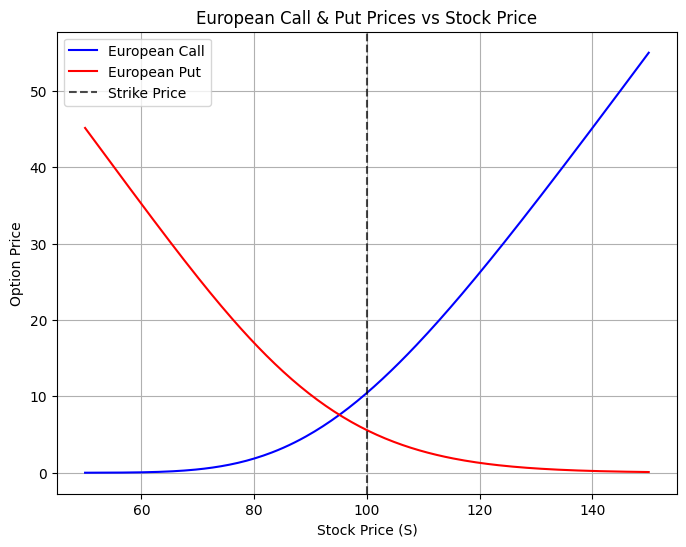

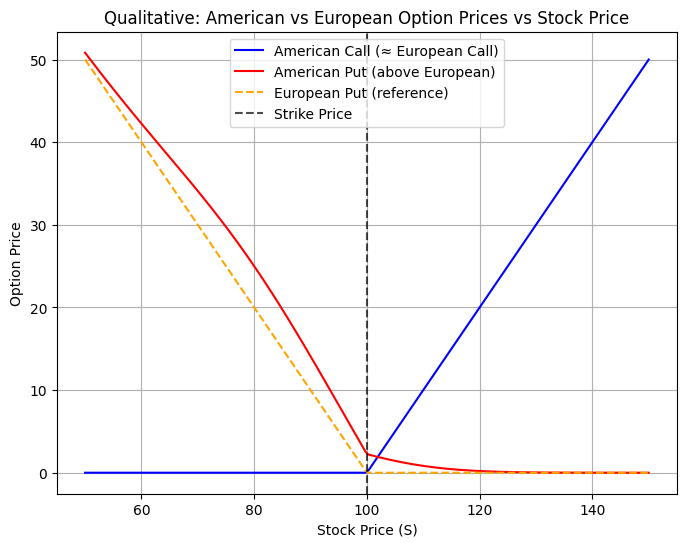

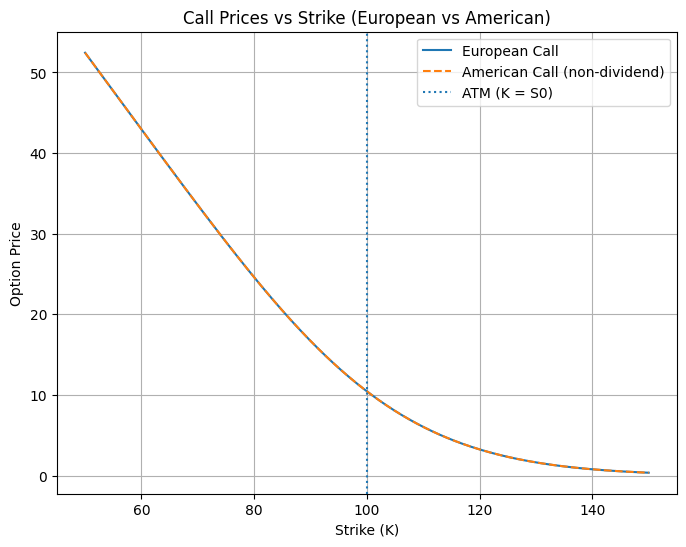

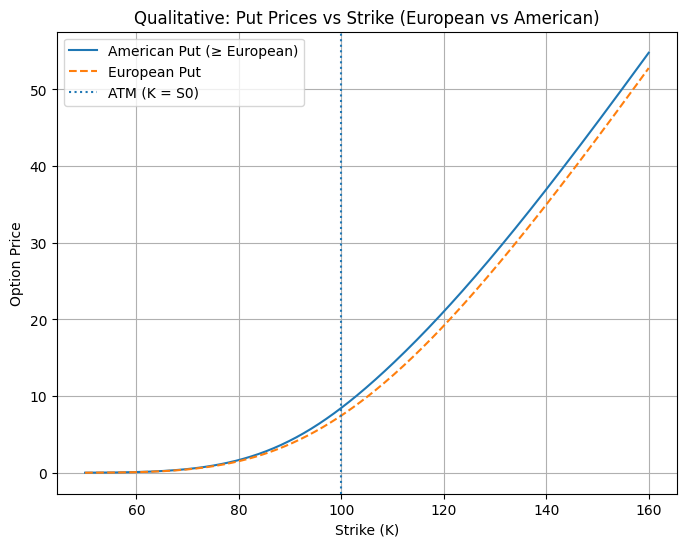

In [ ]:
# Questions 19,20,21,and 22

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# ---------------------------
# Black-Scholes Formulas
# ---------------------------
def bs_call(S, K, T, r, sigma):
    """European call option price (Black-Scholes)"""
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

def bs_put(S, K, T, r, sigma):
    """European put option price (Black-Scholes)"""
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)


# ---------------------------
# 1. European Call & Put vs Stock Price
# ---------------------------
def graph_european_vs_stock():
    K, T, r, sigma = 100, 1, 0.05, 0.2
    S = np.linspace(50, 150, 200)
    call_prices = [bs_call(s, K, T, r, sigma) for s in S]
    put_prices = [bs_put(s, K, T, r, sigma) for s in S]

    plt.figure(figsize=(8,6))
    plt.plot(S, call_prices, label="European Call", color="blue")
    plt.plot(S, put_prices, label="European Put", color="red")
    plt.axvline(K, linestyle="--", color="black", alpha=0.7, label="Strike Price")
    plt.title("European Call & Put Prices vs Stock Price")
    plt.xlabel("Stock Price (S)")
    plt.ylabel("Option Price")
    plt.legend(); plt.grid(True); plt.show()


# ---------------------------
# 2. American (Qualitative) vs Stock Price
# ---------------------------
def graph_american_vs_stock():
    K = 100
    S = np.linspace(50, 150, 200)
    euro_call = np.maximum(S - K, 0)
    euro_put = np.maximum(K - S, 0)

    amer_call = euro_call               # same as European for non-dividend stock
    amer_put = euro_put + 5 * np.exp(-(S-80)**2/500)  # shifted above qualitatively

    plt.figure(figsize=(8,6))
    plt.plot(S, amer_call, label="American Call (≈ European Call)", color="blue")
    plt.plot(S, amer_put, label="American Put (above European)", color="red")
    plt.plot(S, euro_put, linestyle="--", color="orange", label="European Put (reference)")
    plt.axvline(K, linestyle="--", color="black", alpha=0.7, label="Strike Price")
    plt.title("Qualitative: American vs European Option Prices vs Stock Price")
    plt.xlabel("Stock Price (S)")
    plt.ylabel("Option Price")
    plt.legend(); plt.grid(True); plt.show()


# ---------------------------
# 3. European vs American Call vs Strike
# ---------------------------
def graph_call_vs_strike():
    S0, T, r, sigma = 100, 1, 0.05, 0.2
    K = np.linspace(50, 150, 300)
    euro_calls = np.array([bs_call(S0, k, T, r, sigma) for k in K])
    amer_calls = euro_calls.copy()   # identical for non-dividend stocks

    plt.figure(figsize=(8,6))
    plt.plot(K, euro_calls, label="European Call")
    plt.plot(K, amer_calls, linestyle="--", label="American Call (non-dividend)")
    plt.axvline(S0, linestyle=":", label="ATM (K = S0)")
    plt.title("Call Prices vs Strike (European vs American)")
    plt.xlabel("Strike (K)")
    plt.ylabel("Option Price")
    plt.legend(); plt.grid(True); plt.show()


# ---------------------------
# 4. European vs American Put vs Strike (Qualitative)
# ---------------------------
def graph_put_vs_strike():
    S0, T, r, sigma = 100, 1, 0.05, 0.25
    K = np.linspace(50, 160, 300)
    euro_put = np.array([bs_put(S0, k, T, r, sigma) for k in K])
    premium = 2.0 * (1 / (1 + np.exp(-(K - S0) / 8)))  # smooth early exercise premium
    amer_put = euro_put + premium

    plt.figure(figsize=(8,6))
    plt.plot(K, amer_put, label="American Put (≥ European)")
    plt.plot(K, euro_put, linestyle="--", label="European Put")
    plt.axvline(S0, linestyle=":", label="ATM (K = S0)")
    plt.title("Qualitative: Put Prices vs Strike (European vs American)")
    plt.xlabel("Strike (K)")
    plt.ylabel("Option Price")
    plt.legend(); plt.grid(True); plt.show()


# ---------------------------
# Run examples
# ---------------------------
graph_european_vs_stock()
graph_american_vs_stock()
graph_call_vs_strike()
graph_put_vs_strike()


In [ ]:
#Question 25
import numpy as np

def build_binomial_trees(S0, K, T, r, sigma, n, option_type='put'):
    """
    Builds the full binomial trees for stock prices and option values.

    Returns:
        tuple: A tuple containing the stock price tree and the option value tree.
    """
    # 1. Calculate tree parameters
    dt = T / n
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u
    p = (np.exp(r * dt) - d) / (u - d)
    discount = np.exp(-r * dt)

    # 2. Initialize the stock and option trees (as lists of lists)
    stock_tree = [[0.0 for _ in range(i + 1)] for i in range(n + 1)]
    option_tree = [[0.0 for _ in range(i + 1)] for i in range(n + 1)]
    stock_tree[0][0] = S0

    # 3. Build the stock price tree (forward induction)
    for i in range(n):
        for j in range(i + 1):
            stock_tree[i + 1][j] = stock_tree[i][j] * u
            stock_tree[i + 1][j + 1] = stock_tree[i][j] * d

    # 4. Calculate option payoffs at maturity (t=T)
    for j in range(n + 1):
        if option_type == 'put':
            option_tree[n][j] = max(0, K - stock_tree[n][j])
        else: # call
            option_tree[n][j] = max(0, stock_tree[n][j] - K)

    # 5. Calculate option values at earlier nodes (backward induction)
    for i in range(n - 1, -1, -1):
        for j in range(i + 1):
            val_up = option_tree[i + 1][j]
            val_down = option_tree[i + 1][j + 1]
            option_tree[i][j] = discount * (p * val_up + (1 - p) * val_down)

    return stock_tree, option_tree

# --- Main Dynamic Delta Hedging Simulation ---

# 1. Define initial parameters
S0 = 180
K = 182
T = 0.5  # 6 months
r = 0.02
sigma = 0.25
n = 3
path = ['D', 'U', 'D']  # The chosen path: Down -> Up -> Down

# 2. Build the necessary trees
stock_tree, option_tree = build_binomial_trees(S0, K, T, r, sigma, n, option_type='put')
dt = T / n
interest_factor = np.exp(r * dt)

# 3. Initialize hedging portfolio variables
cash_account = 0.0
shares_shorted = 0.0
node_j = 0  # Vertical index in the tree (0 at the top of each step)

# --- Print Header ---
print("--- Dynamic Delta Hedging Simulation for a Short Put ---")
print(f"Path: {' -> '.join(path)}")
print("-" * 100)
print(f"{'Time':<5} {'Action':<20} {'Stock Price':<15} {'Delta':<10} {'Shares Held':<15} {'Cash Flow':<15} {'Cash Account':<15}")
print("-" * 100)

# --- Step 0: Initial Hedge ---
time_step = 0
stock_price = stock_tree[time_step][node_j]
option_price = option_tree[time_step][node_j]

# a. Sell the put option
cash_account += option_price
print(f"{time_step:<5} {'Sell Put':<20} {'-':<15} {'-':<10} {'-':<15} {f'+{option_price:.2f}':<15} {f'{cash_account:.2f}':<15}")

# b. Set up the initial hedge
Pu = option_tree[time_step + 1][node_j]
Pd = option_tree[time_step + 1][node_j + 1]
Su = stock_tree[time_step + 1][node_j]
Sd = stock_tree[time_step + 1][node_j + 1]
delta_long_put = (Pu - Pd) / (Su - Sd)
delta_short_put = -delta_long_put

shares_shorted = delta_short_put
proceeds = shares_shorted * stock_price
cash_account += proceeds
print(f"{time_step:<5} {'Initial Hedge':<20} {f'{stock_price:.2f}':<15} {f'{delta_short_put:.4f}':<10} {f'{-shares_shorted:.4f}':<15} {f'+{proceeds:.2f}':<15} {f'{cash_account:.2f}':<15}")

# --- Loop through the path to rebalance ---
for move in path:
    time_step += 1

    # Update cash account with interest
    cash_account *= interest_factor

    # Determine the new node in the tree based on the move
    if move == 'D':
        node_j += 1
    # if move == 'U', node_j stays the same

    stock_price = stock_tree[time_step][node_j]

    # Calculate the new required hedge if not at expiration
    if time_step < n:
        Pu = option_tree[time_step + 1][node_j]
        Pd = option_tree[time_step + 1][node_j + 1]
        Su = stock_tree[time_step + 1][node_j]
        Sd = stock_tree[time_step + 1][node_j + 1]
        delta_long_put = (Pu - Pd) / (Su - Sd)
        delta_short_put = -delta_long_put
    else: # At expiration, delta is either 0 (OTM) or -1 (ITM) for a long put
        delta_short_put = 1.0 if stock_price < K else 0.0

    # Rebalance the hedge
    required_shares = delta_short_put
    shares_to_trade = required_shares - shares_shorted
    cash_flow = shares_to_trade * stock_price
    cash_account += cash_flow

    action = f"Rebalance ({'Short' if shares_to_trade > 0 else 'Buy Back'})"
    print(f"{time_step:<5} {action:<20} {f'{stock_price:.2f}':<15} {f'{delta_short_put:.4f}':<10} {f'{-required_shares:.4f}':<15} {f'{cash_flow:+.2f}':<15} {f'{cash_account:.2f}':<15}")

    shares_shorted = required_shares

# --- Final Settlement ---
print("-" * 100)
final_stock_price = stock_tree[n][node_j]
print(f"Final Settlement at T={T} years, S_T = {final_stock_price:.2f}")

# a. Close out the short stock position
cost_to_close = shares_shorted * final_stock_price
print(f"-> Cost to buy back {shares_shorted:.4f} shares: ${cost_to_close:.2f}")
cash_account -= cost_to_close

# b. Settle the put option
option_payoff = max(0, K - final_stock_price)
print(f"-> Payout on short put option: ${option_payoff:.2f}")
cash_account -= option_payoff

# --- Final Profit / Loss ---
print(f"\n{'Final Cash Account (Net P/L):':<30} ${cash_account:.4f}")
print("A value close to zero indicates a successful hedge.")

--- Dynamic Delta Hedging Simulation for a Short Put ---
Path: D -> U -> D
----------------------------------------------------------------------------------------------------
Time  Action               Stock Price     Delta      Shares Held     Cash Flow       Cash Account   
----------------------------------------------------------------------------------------------------
0     Sell Put             -               -          -               +13.82          13.82          
0     Initial Hedge        180.00          0.4726     -0.4726         +85.06          98.88          
1     Rebalance (Short)    162.54          0.7447     -0.7447         +44.24          143.45         
2     Rebalance (Buy Back) 180.00          0.5288     -0.5288         -38.86          105.07         
3     Rebalance (Short)    162.54          1.0000     -1.0000         +76.58          182.00         
----------------------------------------------------------------------------------------------------
Final Sett

In [ ]:
#Question 26

S0 = 180
K = 182
r = 0.02
sigma = 0.25
T = 0.5
N = 25
dt = T / N
discount = np.exp(-r * dt)

u = np.exp(sigma * np.sqrt(dt))
d = 1 / u

p = (np.exp(r * dt) - d) / (u - d)

stock_prices = np.zeros((N + 1, N + 1))
stock_prices[0, 0] = S0
for j in range(1, N + 1):
    stock_prices[0, j] = stock_prices[0, j - 1] * d
    for i in range(1, j + 1):
        stock_prices[i, j] = stock_prices[i - 1, j - 1] * u

option_values = np.zeros_like(stock_prices)

option_values[:, N] = np.maximum(K - stock_prices[:, N], 0)

deltas = np.zeros((N, N))
for j in range(N - 1, -1, -1):
    for i in range(j + 1):
        cont_val = discount * (p * option_values[i + 1, j + 1] + (1 - p) * option_values[i, j + 1])
        exer_val = max(K - stock_prices[i, j], 0)
        option_values[i, j] = max(cont_val, exer_val)
        delta_num = option_values[i + 1, j + 1] - option_values[i, j + 1]
        delta_den = stock_prices[i + 1, j + 1] - stock_prices[i, j + 1]
        deltas[i, j] = delta_num / delta_den if delta_den != 0 else 0

option_price = option_values[0, 0]
print(f"American Put option price (N={N}): {option_price:.4f}")

path = [1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0][:N]

cash_account = 0
shares_held = 0

print("\nStep | Stock Price | Delta   | Shares Change | Cash Account")
print("-----------------------------------------------------------")

for step in range(N):
    node_idx = sum(path[:step])
    stock_price = stock_prices[node_idx, step]
    delta = deltas[node_idx, step]

    shares_change = delta - shares_held
    cash_account -= shares_change * stock_price
    if step > 0:
        cash_account *= np.exp(r * dt)
    shares_held = delta

    print(f"{step:<4} | {stock_price:<11.2f} | {delta:<7.4f} | {shares_change:<13.4f} | {cash_account:.4f}")

American Put option price (N=25): 13.0357

Step | Stock Price | Delta   | Shares Change | Cash Account
-----------------------------------------------------------
0    | 180.00      | -0.4756 | -0.4756       | 85.6002
1    | 186.48      | -0.3951 | 0.0804        | 70.6270
2    | 193.19      | -0.3163 | 0.0788        | 55.4234
3    | 186.48      | -0.3947 | -0.0784       | 70.0797
4    | 193.19      | -0.3125 | 0.0823        | 54.2051
5    | 186.48      | -0.3941 | -0.0817       | 69.4655
6    | 193.19      | -0.3079 | 0.0863        | 52.8198
7    | 200.14      | -0.2273 | 0.0806        | 36.7102
8    | 193.19      | -0.3023 | -0.0750       | 51.2219
9    | 200.14      | -0.2178 | 0.0846        | 34.3116
10   | 193.19      | -0.2955 | -0.0777       | 49.3499
11   | 200.14      | -0.2063 | 0.0892        | 31.5048
12   | 207.34      | -0.1301 | 0.0761        | 15.7249
13   | 200.14      | -0.1922 | -0.0620       | 28.1535
14   | 207.34      | -0.1131 | 0.0790        | 11.7694
15   | 200.1

In [ ]:
#Question 27

import numpy as np

S0 = 180
K = 182
r = 0.02
sigma = 0.25
T = 0.5
N = 25
dt = T / N
discount = np.exp(-r * dt)

u = np.exp(sigma * np.sqrt(dt))
d = 1 / u
p = (np.exp(r * dt) - d) / (u - d)

stock_prices = np.zeros((N + 1, N + 1))
stock_prices[0, 0] = S0
for j in range(1, N + 1):
    stock_prices[0, j] = stock_prices[0, j - 1] * d
    for i in range(1, j + 1):
        stock_prices[i, j] = stock_prices[i - 1, j - 1] * u

running_avg = np.zeros_like(stock_prices)
running_avg[0, 0] = S0
for j in range(1, N + 1):
    running_avg[0, j] = (running_avg[0, j - 1] * j + stock_prices[0, j]) / (j + 1)
    for i in range(1, j + 1):
        running_avg[i, j] = (running_avg[i - 1, j - 1] * j + stock_prices[i, j]) / (j + 1)

option_values = np.maximum(K - running_avg[:, N], 0)

deltas = np.zeros((N, N))

for j in range(N - 1, -1, -1):
    for i in range(j + 1):
        cont_val = discount * (p * option_values[i + 1] + (1 - p) * option_values[i])
        exer_val = max(K - running_avg[i, j], 0)
        option_values[i] = max(cont_val, exer_val)
        # Delta calculation using finite differences
        price_up = stock_prices[i + 1, j + 1]
        price_down = stock_prices[i, j + 1]
        if price_up != price_down:
            deltas[i, j] = (option_values[i + 1] - option_values[i]) / (price_up - price_down)
        else:
            deltas[i, j] = 0

print(f"American Asian ATM Put Option Price: {option_values[0]:.4f}")

path = [1 if i % 2 == 0 else 0 for i in range(N)]

cash_account = 0
shares_held = 0

print("\nStep | Stock Price | Delta  | Shares Change | Cash Account")
print("----------------------------------------------------------")

for step in range(N):
    node_idx = sum(path[:step])
    stock_price = stock_prices[node_idx, step]
    delta = deltas[node_idx, step] if step < N - 1 else 0

    shares_change = delta - shares_held
    cash_account -= shares_change * stock_price
    if step > 0:
        cash_account *= np.exp(r * dt)
    shares_held = delta

    print(f"{step:<4} | {stock_price:<11.2f} | {delta:<6.3f} | {shares_change:<13.3f} | {cash_account:.4f}")

American Asian ATM Put Option Price: 33.3152

Step | Stock Price | Delta  | Shares Change | Cash Account
----------------------------------------------------------
0    | 180.00      | -0.199 | -0.199        | 35.7398
1    | 186.48      | -0.201 | -0.002        | 36.1866
2    | 180.00      | -0.200 | 0.001         | 36.0499
3    | 186.48      | -0.203 | -0.003        | 36.5936
4    | 180.00      | -0.201 | 0.001         | 36.3439
5    | 186.48      | -0.205 | -0.003        | 36.9901
6    | 180.00      | -0.203 | 0.002         | 36.6159
7    | 186.48      | -0.207 | -0.004        | 37.3686
8    | 180.00      | -0.204 | 0.003         | 36.8588
9    | 186.48      | -0.208 | -0.005        | 37.7188
10   | 180.00      | -0.204 | 0.004         | 37.0643
11   | 186.48      | -0.210 | -0.005        | 38.0278
12   | 180.00      | -0.205 | 0.005         | 37.2247
13   | 186.48      | -0.211 | -0.006        | 38.2799
14   | 180.00      | -0.205 | 0.005         | 37.3338
15   | 186.48      | -0.21